This project performs an unsupervised clustering analysis on the Wine dataset from scikit-learn. Using K-Means clustering with hyperparameter tuning, we identify natural groupings in the wine samples based on their chemical properties. The analysis includes data preprocessing, model optimization, visualization, and cluster interpretation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

load_wine has DATA and Target. after creating DF for storing the data, TARGET column is created for storing the targets. at the end, df will be a dataframe including both data and target

In [2]:
# Load data and create DataFrame
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target  # True labels for reference only

# Remove target from features before clustering
X = df.drop('target', axis=1)

In [3]:
# preprocessing - only numerical features in this dataset
preprocessor = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('cluster', KMeans(random_state=42))
])

In [4]:
# Parameter grid for GridSearchCV
param_grid = {
    'cluster__n_clusters': range(2, 6),
    'cluster__init': ['k-means++', 'random'],
    'cluster__n_init': [10, 20]  # Added to prevent convergence issues
}

# Custom scoring function with checks
def clustering_scorer(estimator, X):
    X_transformed = estimator.named_steps['preprocessor'].transform(X)
    labels = estimator.predict(X)
    
    # Check if all points are in one cluster
    unique_clusters = np.unique(labels)
    if len(unique_clusters) == 1:
        return -1  # Return worst possible score
    
    #silhouette_score needs scaled data because it is distance sensitive 
    return silhouette_score(X_transformed, labels)

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=clustering_scorer,
    verbose=1  # Added to see progress
)

grid_search.fit(X)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('scaler',
                                                         StandardScaler())])),
                                       ('cluster', KMeans(random_state=42))]),
             param_grid={'cluster__init': ['k-means++', 'random'],
                         'cluster__n_clusters': range(2, 6),
                         'cluster__n_init': [10, 20]},
             scoring=<function clustering_scorer at 0x0000026633E3FEC0>,
             verbose=1)

In [11]:
# Results
print("\nBest parameters:", grid_search.best_params_)
print("Best Silhouette Score:", grid_search.best_score_)
#Silhouette Score measures between -1 (worst) to +1 (best)


Best parameters: {'cluster__init': 'random', 'cluster__n_clusters': 5, 'cluster__n_init': 10}
Best Silhouette Score: 0.21694182087999173


In [6]:
# Visualization
best_model = grid_search.best_estimator_
X_processed = best_model.named_steps['preprocessor'].transform(X)
labels = best_model.predict(X)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

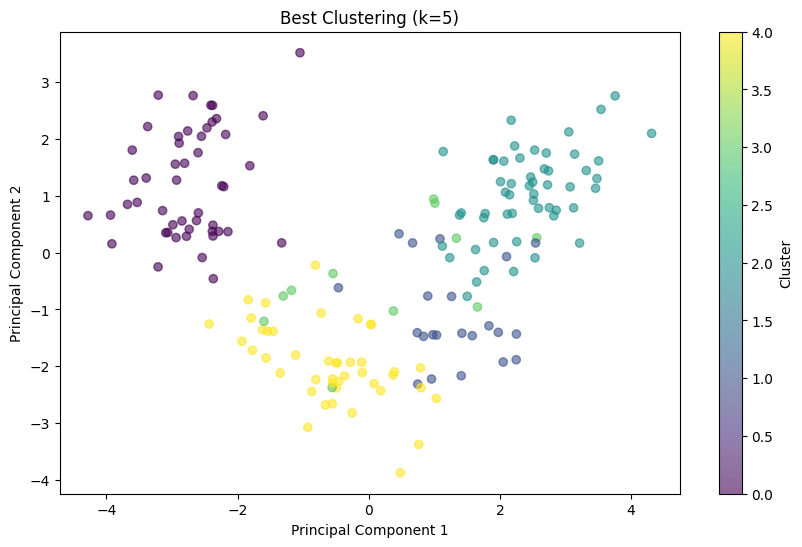

In [7]:
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.title(f'Best Clustering (k={grid_search.best_params_["cluster__n_clusters"]})')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [8]:
# Cluster analysis
cluster_results = X.copy()
cluster_results['cluster'] = labels
print("\nCluster means:")
print(cluster_results.groupby('cluster').mean())


Cluster means:
           alcohol  malic_acid       ash  alcalinity_of_ash   magnesium  \
cluster                                                                   
0        13.151633    3.344490  2.434694          21.438776   99.020408   
1        12.364545    2.313182  2.219545          18.495455  101.000000   
2        13.811698    1.898113  2.445849          16.741509  106.226415   
3        12.439091    2.433636  2.798182          25.000000  109.636364   
4        12.297907    1.714651  2.155814          19.776744   89.395349   

         total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
cluster                                                                     
0             1.678163    0.797959              0.450816         1.163061   
1             2.707727    2.597727              0.265000         2.209545   
2             2.861132    3.016415              0.285472         1.908868   
3             2.480909    2.522727              0.393636         1.710000


=== Cluster Sizes ===
cluster
0    49
1    22
2    53
3    11
4    43
Name: count, dtype: int64

=== Feature Means by Cluster (vs Overall Mean) ===
         proline  magnesium  alcalinity_of_ash  color_intensity  flavanoids  \
cluster                                                                       
0         627.55      99.02              21.44             7.34        0.80   
1         628.32     101.00              18.50             3.54        2.60   
2        1148.91     106.23              16.74             5.66        3.02   
3         592.09     109.64              25.00             3.38        2.52   
4         487.65      89.40              19.78             2.91        1.80   

         alcohol  malic_acid  od280/od315_of_diluted_wines  total_phenols  \
cluster                                                                     
0          13.15        3.34                          1.69           1.68   
1          12.36        2.31                          3.03        

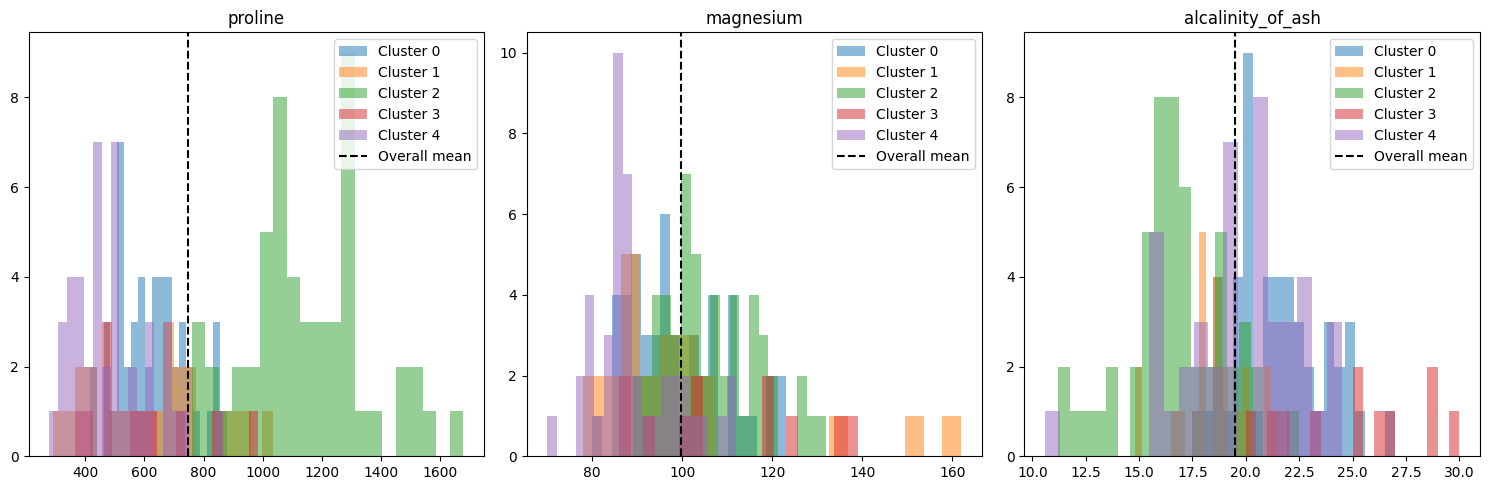


=== Pairplot of Top Features ===


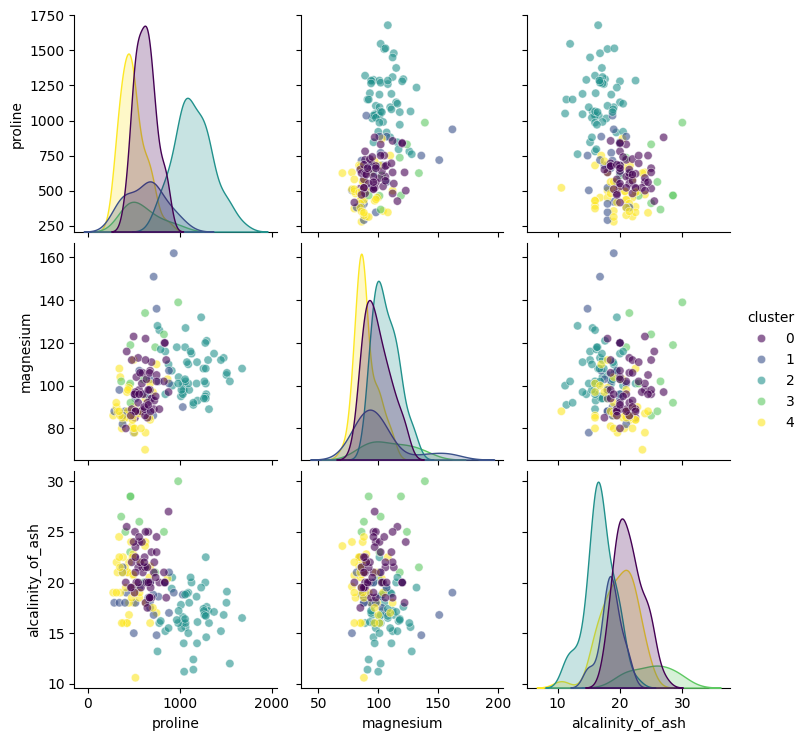

In [9]:
# Create a DataFrame for analysis
cluster_results = X.copy()
cluster_results['cluster'] = labels

# 1. Basic Cluster Statistics
print("\n=== Cluster Sizes ===")
print(cluster_results['cluster'].value_counts().sort_index())

# 2. Feature Means by Cluster with Overall Comparison
print("\n=== Feature Means by Cluster (vs Overall Mean) ===")

# Calculate overall means
overall_means = X.mean()

# Calculate cluster means and compare to overall
cluster_means = cluster_results.groupby('cluster').mean()

# Create comparison DataFrame
comparison_df = cluster_means.copy()
for col in cluster_means.columns:
    comparison_df[f"{col}_diff"] = cluster_means[col] - overall_means[col]
    comparison_df[f"{col}_pct_diff"] = (cluster_means[col] - overall_means[col]) / overall_means[col] * 100

# Sort features by maximum variation across clusters
max_variation = comparison_df.iloc[:, :len(X.columns)].std().sort_values(ascending=False)
comparison_df = comparison_df[max_variation.index.tolist() + 
                            [f"{col}_diff" for col in max_variation.index] +
                            [f"{col}_pct_diff" for col in max_variation.index]]

pd.set_option('display.float_format', '{:.2f}'.format)
print(comparison_df)

# 3. Visualization of Key Differences
print("\n=== Visualizing Key Cluster Differences ===")

# Select top 3 most varying features
top_features = max_variation.index[:3]

plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 3, i)
    for cluster in sorted(cluster_results['cluster'].unique()):
        cluster_data = cluster_results[cluster_results['cluster'] == cluster][feature]
        plt.hist(cluster_data, bins=20, alpha=0.5, label=f'Cluster {cluster}')
    plt.axvline(x=overall_means[feature], color='k', linestyle='--', label='Overall mean')
    plt.title(feature)
    plt.legend()
plt.tight_layout()
plt.show()

# 4. Pairplot of Top Features 
try:
    import seaborn as sns
    print("\n=== Pairplot of Top Features ===")
    sns.pairplot(cluster_results, 
                vars=top_features, 
                hue='cluster', 
                palette='viridis',
                plot_kws={'alpha': 0.6})
    plt.show()
except ImportError:
    print("\nInstall seaborn for pairplot visualization: pip install seaborn")

The Adjusted Rand Index (ARI) is a metric used to evaluate the similarity between two clusterings (e.g., comparing K-Means clusters vs true labels).

Key Properties of ARI:
Range: -1 (worst) to +1 (best)

ARI = 1: Perfect match between clusters and true labels.

ARI = 0: Random clustering (no better than chance).

ARI < 0: Worse than random (rare, indicates severe mismatch).

Expected Outcome for Wine Dataset:
If K-Means finds clusters similar to the true wine classes, ARI will be > 0.5 (moderate to strong agreement).

If K-Means produces random-like clusters, ARI will be close to 0.

If K-Means produces clusters that contradict the true labels, ARI could be negative (unlikely in practice).

Practical Insight for Your Project:
If ARI is high (~0.7+) → K-Means clusters align well with true wine categories.

If ARI is low (~0.0-0.3) → K-Means found different patterns than the original classification.

If Silhouette is high but ARI is low → Clusters are well-separated but don’t match the true labels (interesting for discovering new groupings!).

In [12]:
from sklearn.metrics import adjusted_rand_score

true_labels = df['target']  # True wine classes (0, 1, 2)
pred_labels = best_model.predict(X)

ari = adjusted_rand_score(true_labels, pred_labels)
print(f"Adjusted Rand Index (vs true labels): {ari:.3f}")

Adjusted Rand Index (vs true labels): 0.716


In [ ]:
print("\n=== Clustering Evaluation Metrics ===")
print(f"Silhouette Score: {grid_search.best_score_:.3f}")
print(f"Adjusted Rand Index: {ari:.3f}")  


=== Clustering Evaluation Metrics ===
Silhouette Score: 0.217
Adjusted Rand Index: 0.716
